# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

Rossby utils

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.RossbyInit import *
from utils.WindPerturb import *

In [5]:
wind_N = 100
t_splits = 251

In [6]:
KLSampler = KarhunenLoeve_Sampler(t_splits, wind_N)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

## Data Assimilation

In [7]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [8]:
ls = [6, 7, 8, 9, 10]

### Truth

In [9]:
data_args = initLevel(ls[-1])
true_wind = wind_sample(KLSampler, wind_weight=wind_weight)
truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
truth.step(250000)

250000.0

In [10]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [11]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 800, 600
Hfield[Hy,Hx] = 1.0

R = [0.0001, 0.01, 0.01]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

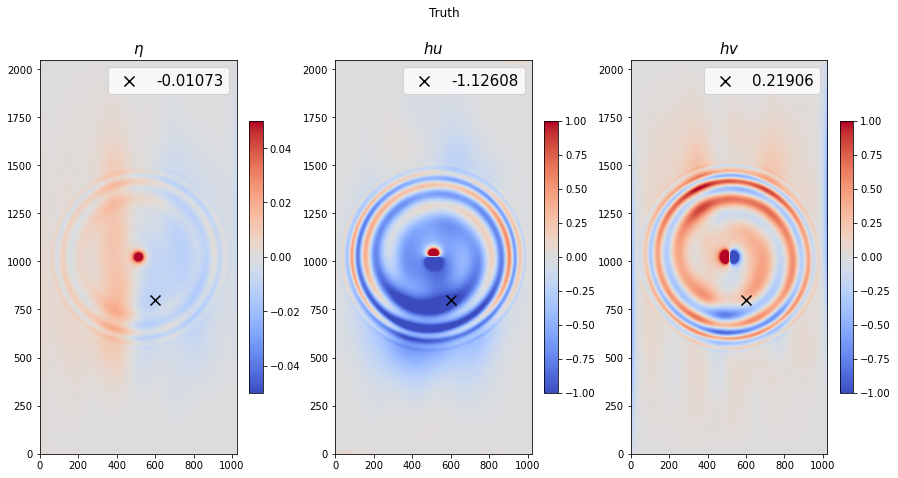

In [12]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### One-level Ensemble

In [13]:
SL_ensemble = []

data_args = initLevel(ls[-1])
for e in range(100):
    wind = wind_sample(KLSampler, wind_weight=wind_weight)
    SL_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))


In [14]:
for e in range(100):
    SL_ensemble[e].step(250000)

In [15]:
SL_state = []

for e in range(100):
    eta, hu, hv = SL_ensemble[e].download(interior_domain_only=True)
    SL_state.append(np.array([eta, hu, hv]))
SL_state = np.moveaxis(SL_state, 0, -1)

In [16]:
SL_prior = copy.deepcopy(SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

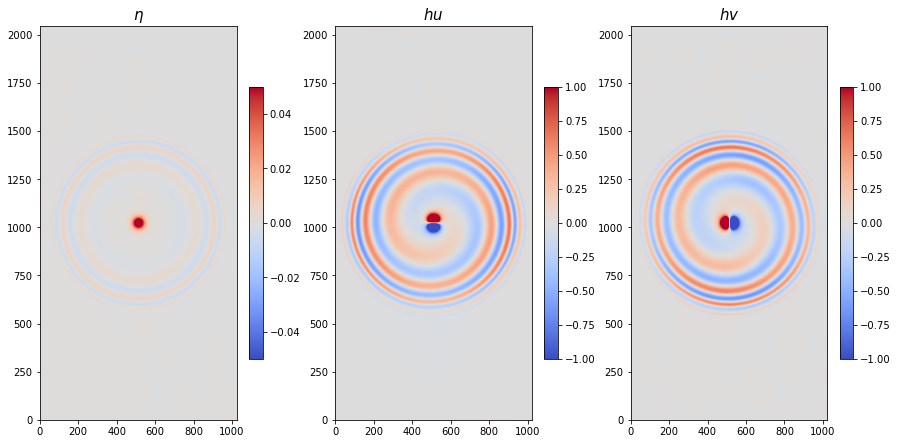

In [17]:
imshow3(np.average(SL_state, axis=-1))

In [18]:
def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.00005, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    # fig.suptitle("ML variance", y=0.9)

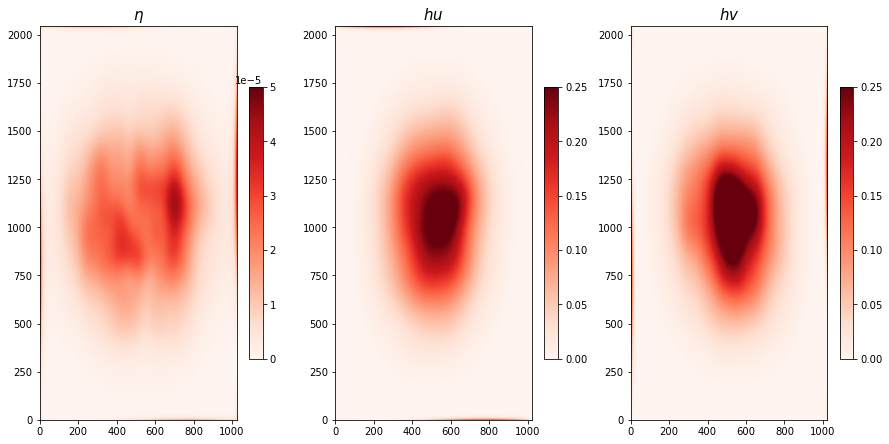

In [19]:
imshow3var(np.var(SL_state, axis=-1))

In [20]:
Xs = np.linspace(0, SL_ensemble[0].nx * SL_ensemble[0].dx, SL_ensemble[0].nx)
Ys = np.linspace(0, SL_ensemble[0].ny * SL_ensemble[0].dy, SL_ensemble[0].ny)
X, Y = np.meshgrid(Xs, Ys)

obs_loc = np.zeros(2)
obs_loc[0] = X[0,Hx]
obs_loc[1] = Y[Hy,0]
dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

r = 2.5*1e7

GC = np.zeros_like(dists)
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        dist = dists[i,j]
        if dist/r < 1: 
            GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

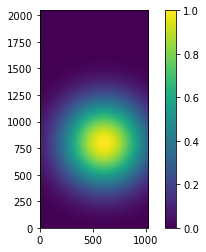

In [21]:
plt.imshow(GC, origin="lower")
plt.colorbar()

In [22]:
SL_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=100)

In [23]:
obs_idxs = [Hy, Hx]

In [24]:
X0 = SL_state
X0mean = np.average(X0, axis=-1)

Y0 = SL_state[:,obs_idxs[0],obs_idxs[1]] + SL_perts.T
Y0mean = np.average(Y0, axis=-1)


In [25]:
SL_XY = (np.tile(GC.flatten(),3)[:,np.newaxis]*1/100*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,))

In [26]:
SL_HXY = SL_XY[:,obs_idxs[0],obs_idxs[1],:]
SL_YY  = SL_HXY + np.diag(R)

SL_K = SL_XY @ np.linalg.inv(SL_YY)

Text(0.5, 0.9, 'Kalman Gain')

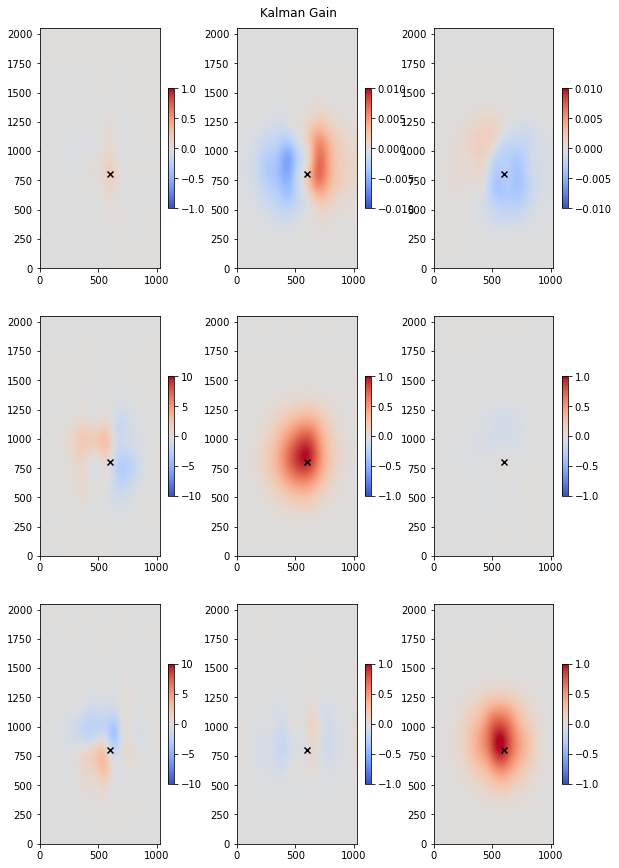

In [27]:
vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(SL_K[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [28]:
SL_state = SL_state + (SL_K @ (obs[:,np.newaxis] - SL_state[:,obs_idxs[0],obs_idxs[1]] - SL_perts.T))


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

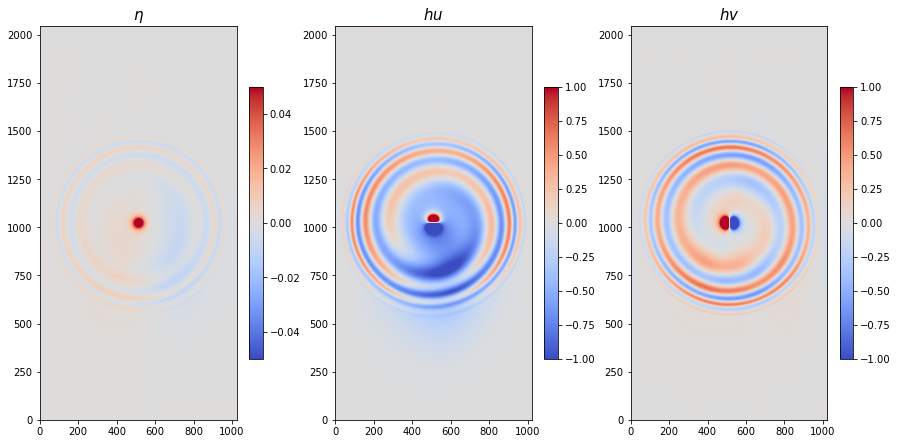

In [29]:
imshow3(np.average(SL_state, axis=-1))

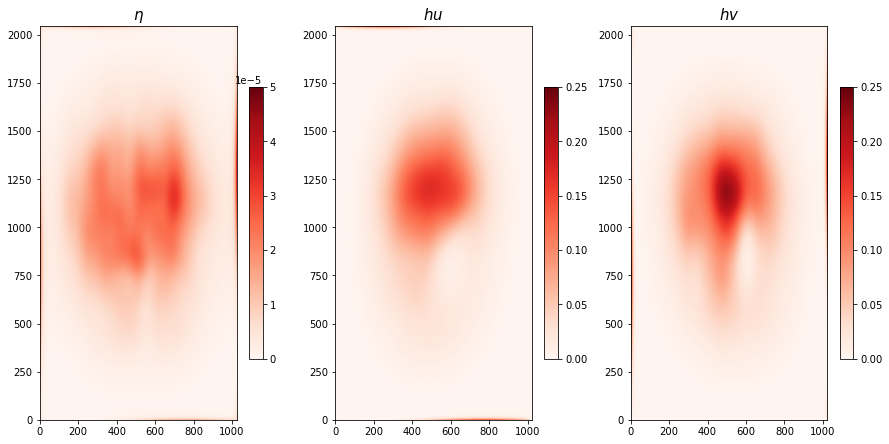

In [30]:
imshow3var(np.var(SL_state, axis=-1))

In [31]:
def SL_EnKF(SL_state, r = 2.5*1e7):
    ## Localisation weights
    Xs = np.linspace(0, SL_ensemble[0].nx * SL_ensemble[0].dx, SL_ensemble[0].nx)
    Ys = np.linspace(0, SL_ensemble[0].ny * SL_ensemble[0].dy, SL_ensemble[0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    obs_loc = np.zeros(2)
    obs_loc[0] = X[0,Hx]
    obs_loc[1] = Y[Hy,0]
    dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

    GC = np.zeros_like(dists)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dist = dists[i,j]
            if dist/r < 1: 
                GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
            elif dist/r >= 1 and dist/r < 2:
                GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))
    
    ## Perturbations
    SL_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=100)

    ## Analysis
    obs_idxs = [Hy, Hx]

    X0 = SL_state
    X0mean = np.average(X0, axis=-1)

    Y0 = SL_state[:,obs_idxs[0],obs_idxs[1]] + SL_perts.T
    Y0mean = np.average(Y0, axis=-1)

    SL_XY = (np.tile(GC.flatten(),3)[:,np.newaxis]*1/100*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,))

    SL_HXY = SL_XY[:,obs_idxs[0],obs_idxs[1],:]
    SL_YY  = SL_HXY + np.diag(R)

    SL_K = SL_XY @ np.linalg.inv(SL_YY)

    ## Update
    SL_state = SL_state + (SL_K @ (obs[:,np.newaxis] - SL_state[:,obs_idxs[0],obs_idxs[1]] - SL_perts.T))

    return SL_state
    

In [32]:
SL_posterior = SL_EnKF(SL_prior)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

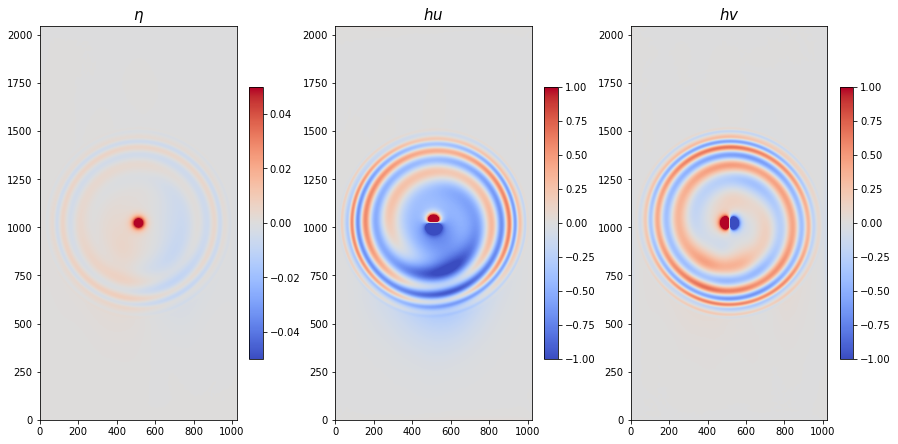

In [33]:
imshow3(np.average(SL_posterior, axis=-1))

### Multi-level Ensemble

In [34]:
vars = np.load("../scripts/Rossby-vars-SpaceTimeWind.npy")
diff_vars = np.load("../scripts/Rossby-diff_vars-SpaceTimeWind.npy")

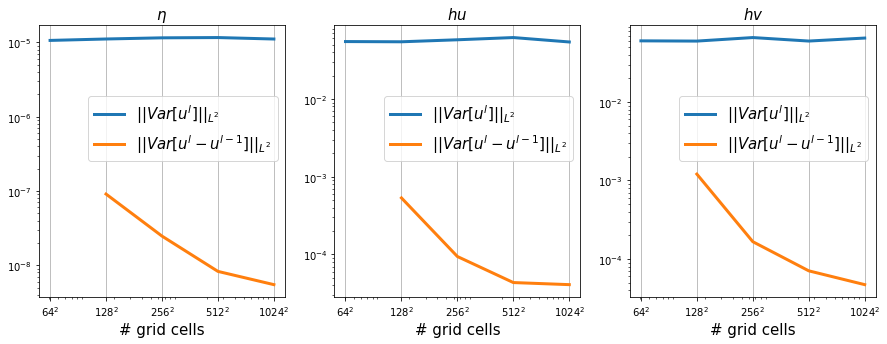

In [35]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, axs = plt.subplots(1,3, figsize=(15,5))

    Nxs = (2**np.array(ls))**2
    for i in range(3):
        axs[i].loglog(Nxs, vars[:,i], label="$|| Var[u^l] ||_{L^2}$", linewidth=3)
        axs[i].loglog(Nxs[1:], diff_vars[1:,i], label="$|| Var[u^l-u^{l-1}] ||_{L^2}$", linewidth=3)
        axs[i].set_xlabel("# grid cells", fontsize=15)
        # axs[i].set_ylabel("variance", fontsize=15)
        axs[i].legend(labelcolor="black", loc=(0.2,0.5), fontsize=15)

        axs[i].set_xticks(Nxs)
        axs[i].xaxis.grid(True)
        axs[i].set_xticklabels(["$64^2$","$128^2$","$256^2$","$512^2$","$1024^2$"])

        # for l_idx, l in enumerate(ls):
        #     axs[i].annotate(str(l), (Nxs[l_idx], 1e-5), color="black")

    axs[0].set_title("$\eta$", fontsize=15)
    axs[1].set_title("$hu$", fontsize=15)
    axs[2].set_title("$hv$", fontsize=15)

In [36]:
# Use the "worst" variable 
vars_hv = vars[:,2]
diff_vars_hv = diff_vars[:,2]

In [37]:
def level_work(l):
    # Cubic work in terms of grid size: 2-space + 1-time
    return (2**(l+1))*(2**l)*(2**l)

In [38]:
allwork = 0
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        allwork += np.sqrt(vars_hv[l_idx] * level_work(l))
    else:
        allwork += np.sqrt(diff_vars_hv[l_idx] * level_work(l))

optNe_ref = np.zeros(len(ls))
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        optNe_ref[l_idx] = np.sqrt(vars_hv[l_idx]/((2**l)**2)) * allwork
    else: 
        optNe_ref[l_idx] = np.sqrt(diff_vars_hv[l_idx]/((2**l)**2)) * allwork

In [39]:
tau = 0.05
Nes = np.int32(np.ceil(1/(tau**2)*optNe_ref))
Nes

array([1194,   85,   16,    6,    3], dtype=int32)

In [40]:
Nes = [100, 75, 50, 25, 10]

In [41]:
ML_ensemble = []

lvl_ensemble = []
data_args = initLevel(ls[0])
for e in range(Nes[0]):
    wind = wind_sample(KLSampler, wind_weight=wind_weight)
    lvl_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))

ML_ensemble.append(lvl_ensemble)
    

for l_idx in range(1,len(Nes)):
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    data_args0 = initLevel(ls[l_idx])
    data_args1 = initLevel(ls[l_idx-1])
    
    for e in range(Nes[l_idx]):
        wind = wind_sample(KLSampler, wind_weight=wind_weight)
        
        lvl_ensemble0.append(CDKLM16.CDKLM16(gpu_ctx, **data_args0, wind=wind))
        lvl_ensemble1.append(CDKLM16.CDKLM16(gpu_ctx, **data_args1, wind=wind))
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

In [42]:
for e in range(Nes[0]):
    ML_ensemble[0][e].step(250000)
    
for l_idx in range(1,len(Nes)):
    for e in range(Nes[l_idx]):
        ML_ensemble[l_idx][0][e].step(250000)
        ML_ensemble[l_idx][1][e].step(250000)

In [43]:
ML_state = []

lvl_state = []
for e in range(Nes[0]):
    eta, hu, hv = ML_ensemble[0][e].download(interior_domain_only=True)
    lvl_state.append(np.array([eta, hu, hv]))
ML_state.append(np.array(lvl_state))
ML_state[0] = np.moveaxis(ML_state[0], 0, -1)

for l_idx in range(1,len(Nes)):
    lvl_state0 = []
    lvl_state1 = []
    for e in range(Nes[l_idx]):
        eta0, hu0, hv0 = ML_ensemble[l_idx][0][e].download(interior_domain_only=True)
        eta1, hu1, hv1 = ML_ensemble[l_idx][1][e].download(interior_domain_only=True)
        lvl_state0.append(np.array([eta0, hu0, hv0]))
        lvl_state1.append(np.array([eta1, hu1, hv1]))
    ML_state.append([np.array(lvl_state0), np.array(lvl_state1)])
    ML_state[l_idx][0] = np.moveaxis(ML_state[l_idx][0], 0, -1)
    ML_state[l_idx][1] = np.moveaxis(ML_state[l_idx][1], 0, -1)

In [44]:
ML_prior_state = copy.deepcopy(ML_state)

In [45]:
def MLmean(state):
    MLest_mean = np.zeros(state[-1][0].shape[:-1])
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

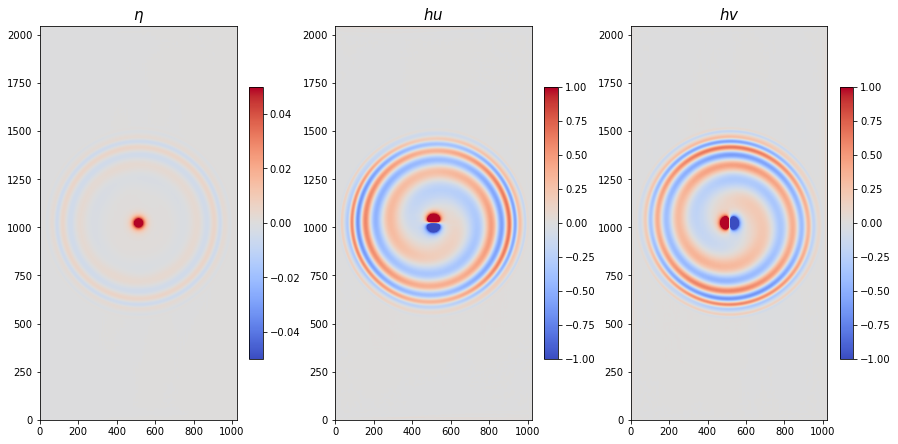

In [46]:
MLest_mean = MLmean(ML_prior_state)
fig, axs = imshow3(MLest_mean)
# fig.suptitle("ML mean", y=0.85)

In [47]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var

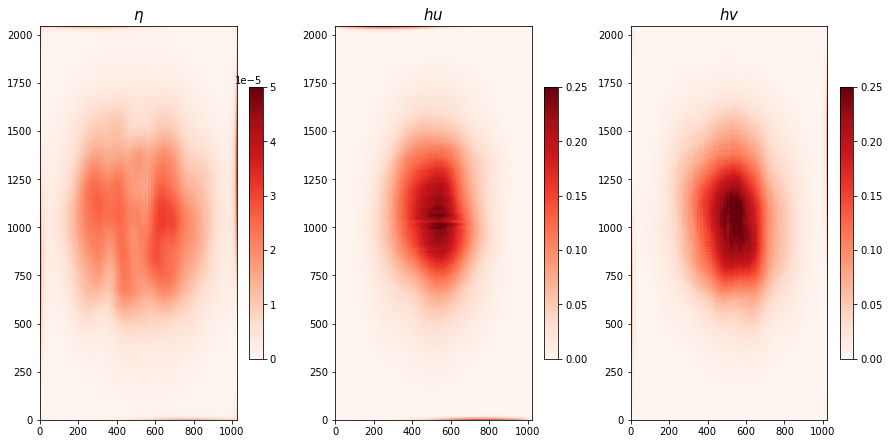

In [48]:
MLest_var = MLvar(ML_prior_state)
imshow3var(MLest_var)

### Kalman gain

In [49]:
Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
X, Y = np.meshgrid(Xs, Ys)

obs_loc = np.zeros(2)
obs_loc[0] = X[0,Hx]
obs_loc[1] = Y[Hy,0]
dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

r = 2.5*1e7

GC = np.zeros_like(dists)
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        dist = dists[i,j]
        if dist/r < 1: 
            GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

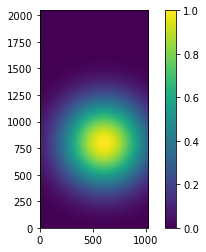

In [50]:
plt.imshow(GC, origin="lower")
plt.colorbar()

In [51]:
ML_perts = []
for l_idx in range(len(ls)):
    ML_perts.append(np.random.multivariate_normal(np.zeros(3), np.diag(R), size=Nes[l_idx]))

In [52]:
from skimage.measure import block_reduce

In [53]:
relax_factor = 1.0

In [54]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),3))

In [55]:
lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][:,obs_idxs[0],obs_idxs[1]] + ML_perts[0].T
Y0mean = np.average(Y0, axis=-1)

lvl_weight = relax_factor * np.ones(np.prod(X0mean.shape))

ML_XY += (lvl_weight[:,np.newaxis]*1/Nes[0]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2).reshape(-1,ML_XY.shape[-1])

In [56]:
for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
    lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

    lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
    lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

    X0 = ML_state[l_idx][0]
    X0mean = np.average(X0, axis=-1)
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)

    Y0 = ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] + ML_perts[l_idx].T
    Y0mean = np.average(Y0, axis=-1)
    Y1 = ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] + ML_perts[l_idx].T
    Y1mean = np.average(Y1, axis=-1)

    lvl_weight = np.tile(block_reduce(GC, block_size=(2**(ls[-1]-l),2**(ls[-1]-l)), func=np.mean).flatten(),3)

    ML_XY += (relax_factor * lvl_weight[:,np.newaxis] * ( 1/Nes[l_idx]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T) - 1/Nes[l_idx]*((X1-X1mean[:,:,:,np.newaxis]).reshape(-1,X1.shape[-1]) @ (Y1 - Y1mean[:,np.newaxis]).T) )).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2).reshape(-1,ML_XY.shape[-1])


In [57]:
ML_HXY = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (3,))[:,obs_idxs0[0],obs_idxs0[1],:]
ML_YY  = ML_HXY + np.diag(R)

ML_K = ML_XY @ np.linalg.inv(ML_YY)

Text(0.5, 0.9, 'Kalman Gain')

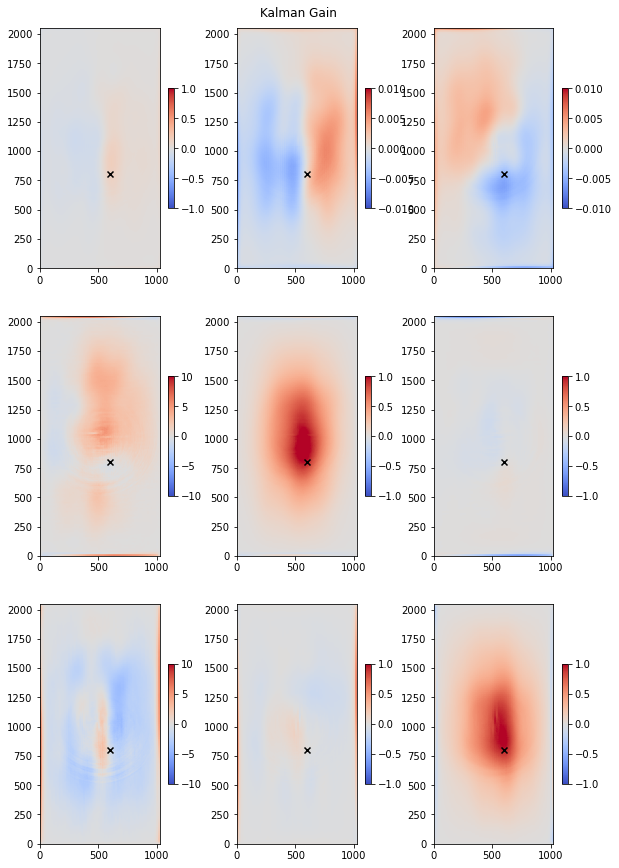

In [58]:
ML_K_field = ML_K.reshape(ML_state[-1][0].shape[:-1] + (3,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

### Update

In [59]:
lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

ML_state[0] = ML_state[0] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[0][:,obs_idxs[0],obs_idxs[1]] - ML_perts[0].T)).reshape(ML_state[-1][0].shape[:-1] + (Nes[0],)), block_size=(1,2**(ls[-1]-ls[0]), 2**(ls[-1]-ls[0]), 1), func=np.mean)

for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
    lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

    lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
    lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

    ML_state[l_idx][0] = ML_state[l_idx][0] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l), 2**(ls[-1]-l), 1), func=np.mean)
    ML_state[l_idx][1] = ML_state[l_idx][1] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l+1), 2**(ls[-1]-l+1), 1), func=np.mean)

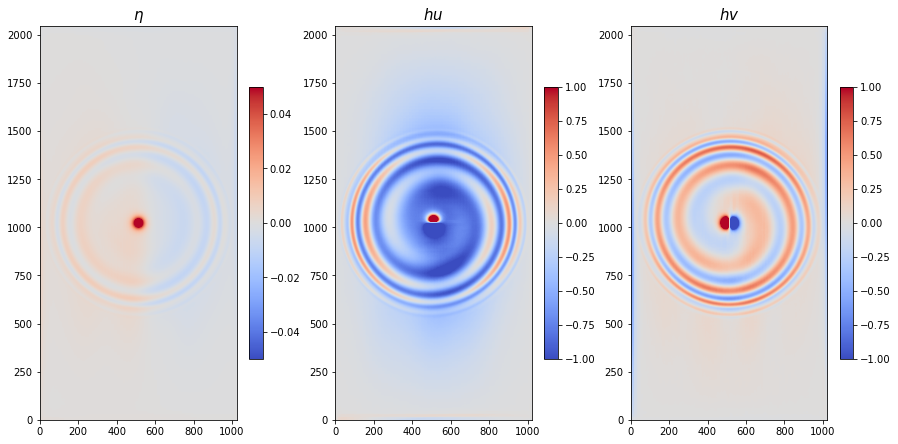

In [60]:
MLest_mean = MLmean(ML_state)
fig, axs = imshow3(MLest_mean)
# fig.suptitle("Posterior ML mean", y=0.9)

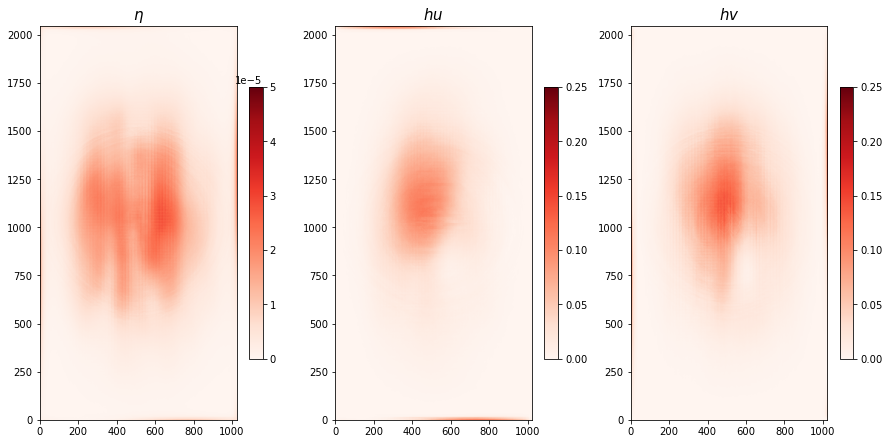

In [61]:
MLest_var = MLvar(ML_state)
imshow3var(MLest_var)

In [64]:
def ML_EnKF(ML_state, r = 2.5*1e7, relax_factor = 1.0):
    ## Localisation
    Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
    Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    obs_loc = np.zeros(2)
    obs_loc[0] = X[0,Hx]
    obs_loc[1] = Y[Hy,0]
    dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

    GC = np.zeros_like(dists)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dist = dists[i,j]
            if dist/r < 1: 
                GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
            elif dist/r >= 1 and dist/r < 2:
                GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

    ## Perturbations
    ML_perts = []
    for l_idx in range(len(ls)):
        ML_perts.append(np.random.multivariate_normal(np.zeros(3), np.diag(R), size=Nes[l_idx]))

    ## Analysis
    ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),3))

    lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
    lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    X0 = ML_state[0]
    X0mean = np.average(X0, axis=-1)

    Y0 = ML_state[0][:,obs_idxs[0],obs_idxs[1]] + ML_perts[0].T
    Y0mean = np.average(Y0, axis=-1)

    lvl_weight = relax_factor * np.ones(np.prod(X0mean.shape))

    ML_XY += (lvl_weight[:,np.newaxis]*1/Nes[0]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2).reshape(-1,ML_XY.shape[-1])

    for l_idx in range(1,len(ls)):
        l = ls[l_idx]

        lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
        lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
        lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        X0 = ML_state[l_idx][0]
        X0mean = np.average(X0, axis=-1)
        X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
        X1mean = np.average(X1, axis=-1)

        Y0 = ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] + ML_perts[l_idx].T
        Y0mean = np.average(Y0, axis=-1)
        Y1 = ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] + ML_perts[l_idx].T
        Y1mean = np.average(Y1, axis=-1)

        lvl_weight = relax_factor * np.tile(block_reduce(GC, block_size=(2**(ls[-1]-l),2**(ls[-1]-l)), func=np.mean).flatten(),3)

        ML_XY += (lvl_weight[:,np.newaxis] * ( 1/Nes[l_idx]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T) - 1/Nes[l_idx]*((X1-X1mean[:,:,:,np.newaxis]).reshape(-1,X1.shape[-1]) @ (Y1 - Y1mean[:,np.newaxis]).T) )).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2).reshape(-1,ML_XY.shape[-1])

    ## Update
    lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
    lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    ML_state[0] = ML_state[0] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[0][:,obs_idxs[0],obs_idxs[1]] - ML_perts[0].T)).reshape(ML_state[-1][0].shape[:-1] + (Nes[0],)), block_size=(1,2**(ls[-1]-ls[0]), 2**(ls[-1]-ls[0]), 1), func=np.mean)

    for l_idx in range(1,len(ls)):
        l = ls[l_idx]

        lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
        lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
        lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        ML_state[l_idx][0] = ML_state[l_idx][0] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l), 2**(ls[-1]-l), 1), func=np.mean)
        ML_state[l_idx][1] = ML_state[l_idx][1] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l+1), 2**(ls[-1]-l+1), 1), func=np.mean)

    return ML_state

In [65]:
ML_posterior_state = ML_EnKF(ML_prior_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

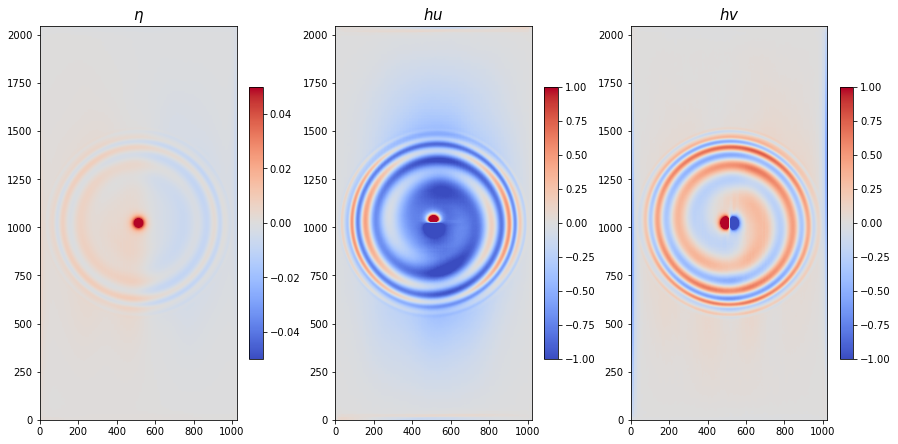

In [66]:
MLest_mean = MLmean(ML_posterior_state)
imshow3(MLest_mean)

In [67]:
def ML_diff(ML1, ML2):
    assert len(ML1) == len(ML2), "Both states need to have same number of levels"
    assert len(ML1[0]) == len(ML2[0]), "The levels have to have same number of member in both states"
    for l in range(1,len(ML1)):
        assert len(ML1[l][0]) == len(ML2[l][0]), "The levels have to have same number of member in both states"
        assert len(ML1[l][1]) == len(ML2[l][1]), "The levels have to have same number of member in both states"
    MLdiff = copy.deepcopy(ML1)
    
    MLdiff[0] = MLdiff[0] - ML2[0]
    for l in range(1,len(ML1)):
        MLdiff[l][0] = MLdiff[l][0] - ML2[l][0]
        MLdiff[l][1] = MLdiff[l][1] - ML2[l][1]
    
    return MLdiff

In [68]:
ML_diff(ML_prior_state, ML_posterior_state)

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.